In [2]:
# === Block 1: Import Libraries & Load Data ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load dataset
df = pd.read_csv("synthetic_retail_transactions_1000.csv", parse_dates=['InvoiceDate'])
df.head()

,CustomerID,InvoiceNo,InvoiceDate,Amount
0,C080,1001,2025-07-20,415.56
1,C010,1002,2024-08-21,578.77
2,C044,1003,2024-12-11,1381.46
3,C091,1004,2025-06-03,1246.91
4,C071,1005,2025-10-21,229.58


In [3]:
# === Block 2: Data Cleaning ===

# Drop missing CustomerID (if any)
df = df.dropna(subset=['CustomerID'])

# Remove transactions with zero or negative amounts (if any)
df = df[df['Amount'] > 0]

# Convert InvoiceNo to string (keeps consistency)
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

# Quick info check
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CustomerID   1000 non-null   object        
 1   InvoiceNo    1000 non-null   object        
 2   InvoiceDate  1000 non-null   datetime64[ns]
 3   Amount       1000 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 31.4+ KB
None


,CustomerID,InvoiceNo,InvoiceDate,Amount
0,C080,1001,2025-07-20,415.56
1,C010,1002,2024-08-21,578.77
2,C044,1003,2024-12-11,1381.46
3,C091,1004,2025-06-03,1246.91
4,C071,1005,2025-10-21,229.58


In [4]:
# === Block 3: RFM Feature Engineering ===

# Define snapshot date (1 day after the last transaction in dataset)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Aggregate RFM metrics for each customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',                                     # Frequency
    'Amount': 'sum'                                           # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Preview
print(rfm.shape)
rfm.head()

(100, 4)


,CustomerID,Recency,Frequency,Monetary
0,C001,68,9,11026.76
1,C002,65,8,9380.64
2,C003,90,10,9561.04
3,C004,59,10,12457.83
4,C005,322,6,6605.88


         Recency   Frequency      Monetary
count  100.00000  100.000000    100.000000
mean    72.24000   10.000000  10307.940500
std     78.70006    2.919804   3382.775063
min      1.00000    4.000000   3294.560000
25%     21.00000    8.000000   8421.405000
50%     48.50000    9.500000   9776.525000
75%     88.50000   12.000000  12342.352500
max    464.00000   18.000000  18622.560000


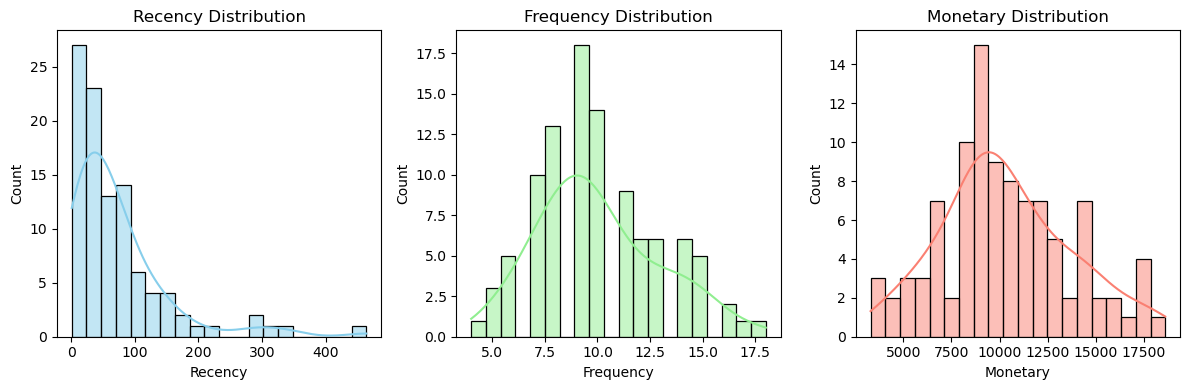

In [5]:
# === Block 4: Explore RFM Data ===

# Summary statistics
print(rfm.describe())

# Plot histograms
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.histplot(rfm['Recency'], kde=True, bins=20, color="skyblue")
plt.title('Recency Distribution')

plt.subplot(1,3,2)
sns.histplot(rfm['Frequency'], kde=True, bins=20, color="lightgreen")
plt.title('Frequency Distribution')

plt.subplot(1,3,3)
sns.histplot(rfm['Monetary'], kde=True, bins=20, color="salmon")
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

In [6]:
# === Block 5: Scale RFM Data ===
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Check scaled data (first 5 rows)
rfm_scaled[:5]

array([[-0.05414685, -0.3442142 ,  0.21356453],
       [-0.0924583 , -0.68842839, -0.27550518],
       [ 0.22680379,  0.        , -0.22190753],
       [-0.1690812 ,  0.        ,  0.63874192],
       [ 3.18955596, -1.37685678, -1.09989897]])

C:\Users\rjimm\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\rjimm\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\rjimm\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rjimm\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

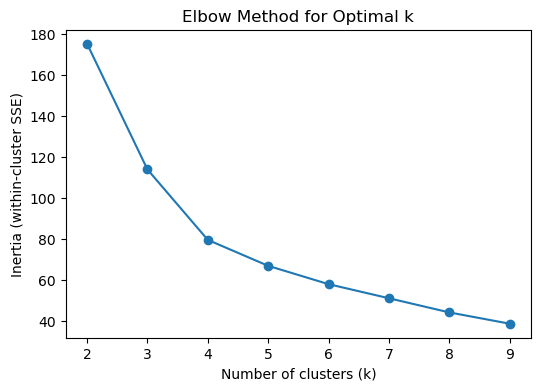

In [7]:
# === Block 6: Elbow Method for KMeans ===
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 10)  # try between 2 and 9 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow Method for Optimal k")
plt.show()

In [8]:
# === Block 7: Apply KMeans Clustering ===

# Fit KMeans with chosen number of clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Preview clustered data
rfm.head()

# Cluster summary
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

print(cluster_summary)

        Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         301.9       7.6   7951.4     7
1          60.3      10.0  10407.3    42
2          46.1       7.2   6885.7    28
3          55.9      14.1  15009.9    23


C:\Users\rjimm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


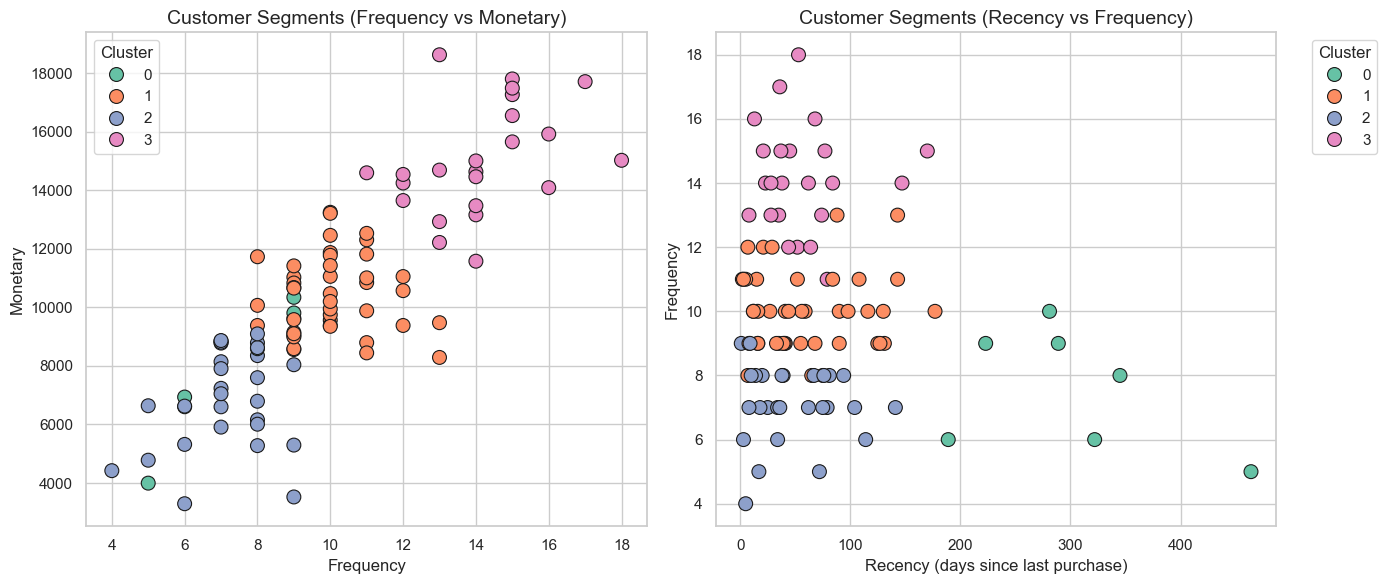

In [11]:
# === Block 8: Improved Cluster Visualization ===
import seaborn as sns
import matplotlib.pyplot as plt

# Use seaborn’s own style
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Frequency vs Monetary
sns.scatterplot(
    data=rfm, x="Frequency", y="Monetary",
    hue="Cluster", palette="Set2", s=100, ax=axes[0], edgecolor="k"
)
axes[0].set_title("Customer Segments (Frequency vs Monetary)", fontsize=14)
axes[0].set_xlabel("Frequency", fontsize=12)
axes[0].set_ylabel("Monetary", fontsize=12)

# Plot 2: Recency vs Frequency
sns.scatterplot(
    data=rfm, x="Recency", y="Frequency",
    hue="Cluster", palette="Set2", s=100, ax=axes[1], edgecolor="k"
)
axes[1].set_title("Customer Segments (Recency vs Frequency)", fontsize=14)
axes[1].set_xlabel("Recency (days since last purchase)", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)

# Move legend outside for clarity
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Cluster")
plt.tight_layout()
plt.show()

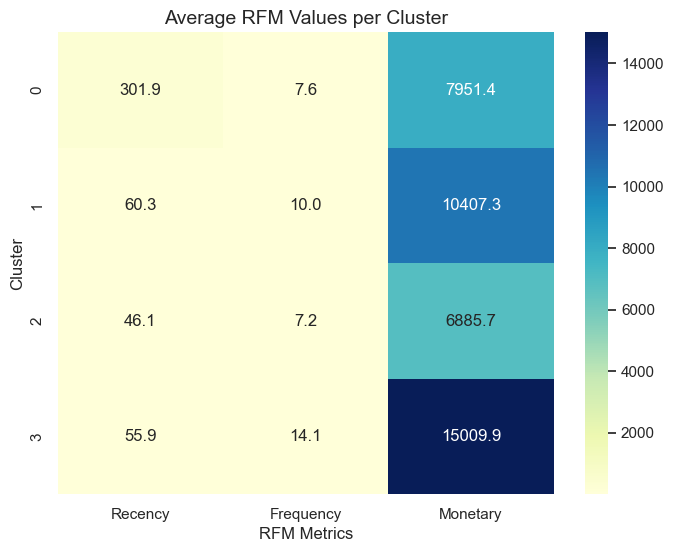

,Recency,Frequency,Monetary
Cluster,,,
0,301.857143,7.571429,7951.440000
1,60.309524,10.023810,10407.323333
2,46.142857,7.178571,6885.683929
3,55.913043,14.130435,15009.880000


In [12]:
# === Block 9: Cluster Profiling Heatmap ===
import seaborn as sns
import matplotlib.pyplot as plt

# Group by cluster and take mean of R, F, M
cluster_profile = rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_profile, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Average RFM Values per Cluster", fontsize=14)
plt.xlabel("RFM Metrics", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.show()

cluster_profile

Segment
Medium-Value Active    42
Recent Buyers          28
VIP / High-Value       23
Churned / Inactive      7
Name: count, dtype: int64


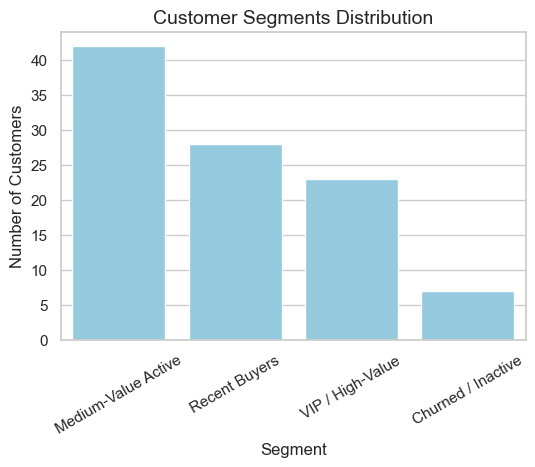

In [19]:
# === Block 10: Segment Labels & Insights (Seaborn v0.14+ warning-free) ===
cluster_labels = {0: "Churned / Inactive", 
                  1: "Medium-Value Active", 
                  2: "Recent Buyers", 
                  3: "VIP / High-Value"}

rfm['Segment'] = rfm['Cluster'].map(cluster_labels)

# Preview
rfm.head()

# Count of customers per segment
segment_counts = rfm['Segment'].value_counts()
print(segment_counts)

# Countplot without warnings
plt.figure(figsize=(6,4))
sns.countplot(
    x='Segment',
    data=rfm,
    order=segment_counts.index,
    color="skyblue"  # use color instead of palette
)
plt.title("Customer Segments Distribution", fontsize=14)
plt.xlabel("Segment", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.xticks(rotation=30)
plt.show()